In [2]:
import pyrootutils
import omegaconf
from omegaconf import OmegaConf
import os
import hydra
from hydra import compose, initialize
from pathlib import Path
import torch

In [3]:
root = pyrootutils.setup_root('.', pythonpath=True)
os.chdir(root)

In [4]:
run_dir = root / 'outputs/cifar10_resnet/runs/crop_flip/'

In [5]:
with initialize(version_base=None, config_path= '..' / run_dir.relative_to(Path.cwd()) / '.hydra'):
    cfg = compose(config_name="config", return_hydra_config=True, overrides=["paths.output_dir=notebooks/tmp"])

In [6]:
datamodule = hydra.utils.instantiate(cfg.dmt.datamodule)
model = hydra.utils.instantiate(cfg.dmt.model)

In [7]:
trainer = hydra.utils.instantiate(cfg.dmt.trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
metrics = trainer.test(model=model, datamodule=datamodule, ckpt_path= run_dir / 'lightning_logs/version_0/checkpoints/epoch=199-step=78200.ckpt')

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /home/cyanos/Workspace/Learning/Benchmark/cv/ten/outputs/cifar10_resnet/runs/crop_flip/lightning_logs/version_0/checkpoints/epoch=199-step=78200.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/cyanos/Workspace/Learning/Benchmark/cv/ten/outputs/cifar10_resnet/runs/crop_flip/lightning_logs/version_0/checkpoints/epoch=199-step=78200.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9372000098228455
        test/loss           0.24650409817695618
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [9]:
train_loader = datamodule.train_dataloader()

In [10]:
model.cuda()
model.eval()
features = []
all_labels = []
train_iter = iter(train_loader)
with torch.no_grad():
    for i in range(100):
        batch = next(train_iter)
        images, labels = batch
        all_labels.append(labels)
        images, labels = images.cuda(), labels.cuda()
        features.append(model.net.feature(images).detach().cpu())
features = torch.concat(features)

In [11]:
features.shape

torch.Size([12800, 64])

## Feature analysis (using PCA)

In [12]:
import numpy as np
from sklearn import decomposition
from matplotlib import pyplot as plt

In [13]:
X_training = features.detach().cpu().numpy()
y_training = labels.cpu().numpy()

In [14]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_training)

PCA(n_components=2)

In [15]:
print(pca.explained_variance_ratio_)

[0.16363035 0.13543673]


In [16]:
X = pca.transform(X_training)

In [17]:
X.shape

(12800, 2)

ValueError: 'c' argument has 128 elements, which is inconsistent with 'x' and 'y' with size 12800.

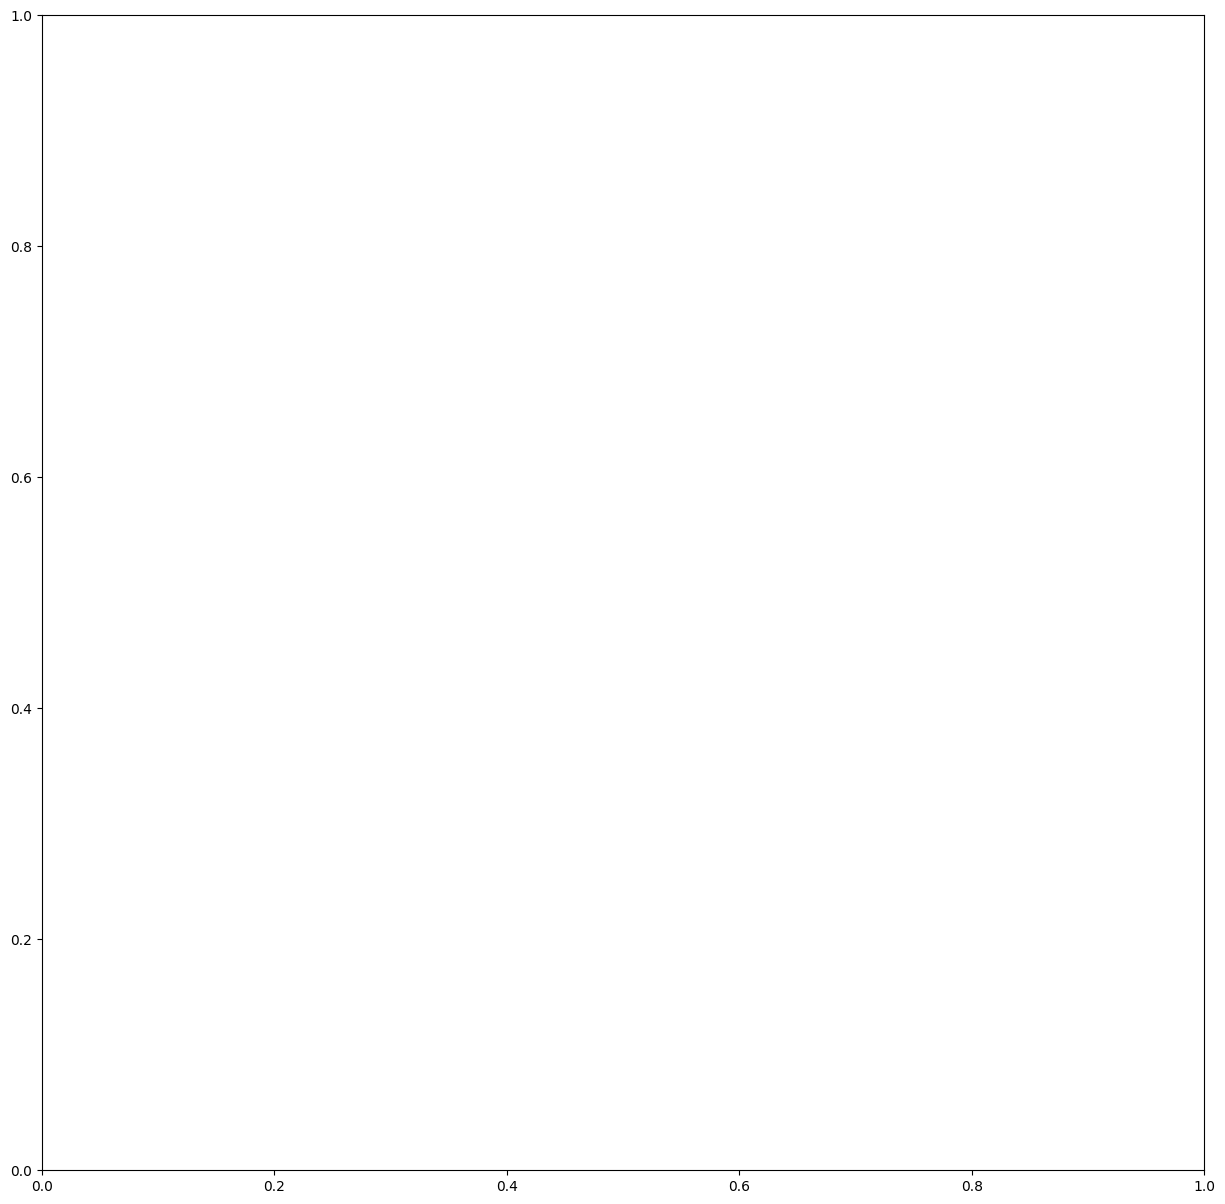

In [18]:
plt.figure( figsize=(15,15) )
plt.scatter( X[:, 0], X[:, 1], c=y_training, cmap='tab10' )
# plt.colorbar()
plt.show()